In [1]:
import matplotlib.pyplot as plt
import cupy as cp
from tqdm import tqdm

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
num_classes = 10

#
# make a matrix each column of which represents an images in a vector form 
#
images  = cp.empty((num_image, size_row * size_col), dtype=float)
labels  = cp.empty(num_image, dtype=int)

for cnt, line in enumerate(data):

    line_data   = line.split(',')
    label       = int(line_data[0])
    im_vector   = cp.array(list(map(int, line_data[1:])))

    labels[cnt]    = label
    images[cnt]    = im_vector

# one-hot
labels = cp.eye(num_classes)[labels]
images = images / 255
    
# Split Data
train_images = images[:6000]
train_labels = labels[:6000]
test_images = images[6000:]
test_labels = labels[:6000]

print(train_images.shape)


(6000, 784)


In [2]:
# Define module

def sigmoid(x):
    return 1 / (1 + cp.exp(-x))

class Model:
    def __init__(self, in_shapes, out_shapes):
        std = 1
        self.weight_1 = cp.random.normal(0, std, (196, in_shapes))
        self.weight_2 = cp.random.normal(0, std, (49, 196))
        self.weight_3 = cp.random.normal(0, std, (out_shapes, 49))
        
        self.node_1 = 0
        self.node_2 = 0
        self.node_3 = 0
        self.node_4 = 0
    
    def __call__(self, x):
        x = x.T
        batch = x.shape[-1]
        
        self.node_1 = x
        x = sigmoid(self.weight_1 @ x)
        
        self.node_2 = x
        x = sigmoid(self.weight_2 @ x)
        
        
        self.node_3 = x
        x = sigmoid(self.weight_3 @ x)
        
        self.node_4 = x
        return x.T
    
    def backprop(self, preds, labels, lr):
        batch_size = preds.shape[0]
        preds, label = preds.T, labels.T
        
        error_4 = preds - label
        error_3 = self.weight_3.T @ error_4 * (self.node_3 * (1 - self.node_3))
        error_2 = self.weight_2.T @ error_3 * (self.node_2 * (1 - self.node_2))
        
        self.weight_3 -= lr * error_4 @ self.node_3.T / batch_size
        self.weight_2 -= lr * error_3 @ self.node_2.T / batch_size
        self.weight_1 -= lr * error_2 @ self.node_1.T / batch_size
        

        
class BinaryCrossEntropy:
    labels = 0
    preds = 0
    def __call__(self, preds, labels):
        self.labels = labels
        self.preds = preds
        
        return -(labels * cp.log(preds) + (1 - labels) * cp.log(1 - preds)).mean()
    
class LearningRateScheduler:
    def __init__(self, init_lr, final_step, warm_up_step = 0):
        self.init_lr = init_lr
        self.final_step = final_step
        self.warm_up_step = warm_up_step
        self.lr = 0
        self._step = 0
    
    def step(self):
        self._step += 1
        if (step < self.warm_up_step):
            self.lr = (self.init_lr / self.warm_up_step) * self._step
        else:
            self.lr = (cp.cos(cp.pi * ((self._step - self.warm_up_step) / (self.final_step - self.warm_up_step))) + 1) / 2 * self.init_lr
        
    def get_lr(self):
        return self.lr

In [3]:
def compute_acc(preds, labels):
    pred_nums = cp.argmax(preds, axis=1)
    lable_nums = cp.argmax(labels, axis=1)
    num_correct = (pred_nums == lable_nums).sum()
    return (pred_nums == lable_nums).sum() / preds.shape[0]

In [4]:
epoch = 100000
warm_up_epoch = epoch // 10
initial_lr = 20

model = Model(784, 10)

criterion = BinaryCrossEntropy()
lr = LearningRateScheduler(initial_lr, epoch, warm_up_epoch)

In [5]:
preds = model(train_images)
model.backprop(preds, train_labels, 0.01)
print(preds.shape)
loss = criterion(preds, train_labels)

(6000, 10)


In [6]:
accuracyes = []
losses = []
lrs = []

for step in tqdm(range(epoch)):
    preds = model(train_images)
    loss = criterion(preds, train_labels)
    acc = compute_acc(preds, train_labels)
    
    model.backprop(preds, train_labels, lr.lr)
    
    accuracyes += [acc]
    losses += [loss]
    lrs += [lr.lr]
    
    lr.step()

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [39:26<00:00, 42.25it/s]


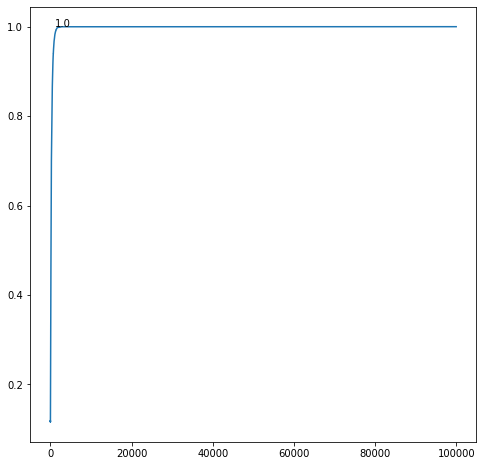

In [7]:
plt.figure(figsize=(8, 8))
plt.plot(accuracyes)
plt.text(1000, 1, f'{accuracyes[-1]}')
plt.show()

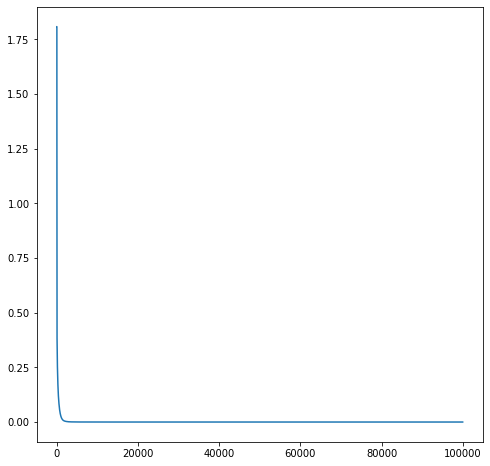

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(losses)
plt.show()

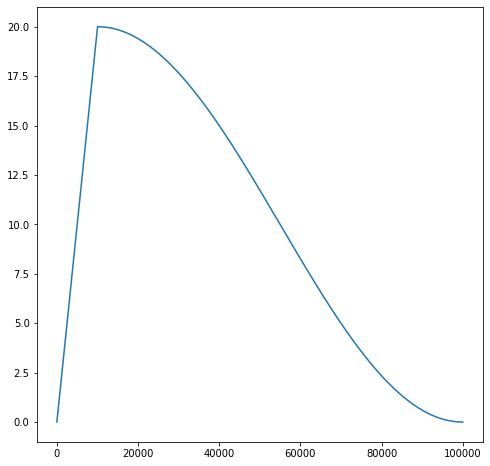

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(lrs)
plt.show()